In [15]:
import numpy as np
import matplotlib.pyplot as plt
import gtsam

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform

import sys
sys.path.append("/home/masonbp/ford/fastsam3d")

from segment_track.observation import Observation
from segment_track.segment import Segment
from segment_track.tracker import Tracker, Cylinder
from segment_track.fastsam_wrapper import FastSAMWrapper

from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.object.object import Object

In [2]:
bag = "/home/masonbp/data/motlee_jan_2024/00/RR08.bag"
img_data = ImgData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/d455/color/image_raw/compressed",
    time_tol=.0333333,
)
pose_data = PoseData(
    data_file=bag,
    file_type='bag',
    topic="/RR08/world",
    time_tol=.4,
    interp=True
)
t0 = np.max([img_data.t0, pose_data.t0])
img_data.set_t0(img_data.t0 - t0)
pose_data.set_t0(pose_data.t0 - t0)

<Axes: xlabel='x', ylabel='y'>

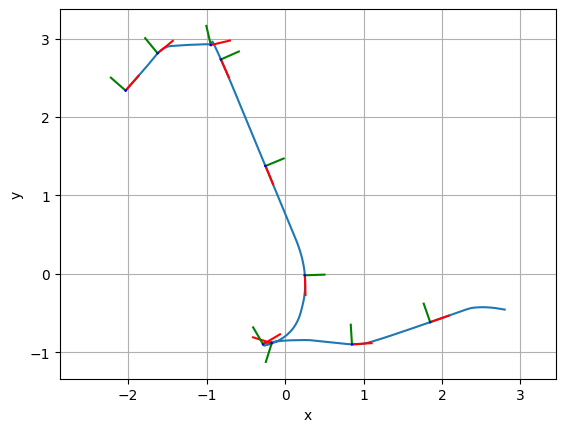

In [3]:
t0 = 104
tf = 120
pose_data.plot2d(t0=100, tf=120, pose=False, dt=.1)
pose_data.plot2d(t0=100, tf=120, trajectory=False, pose=True, dt=2., axis_len=.25)
# pose_data.plot2d(t0=t0, tf=tf, trajectory=True, pose=True, dt=2., axis_len=.25)

<Axes: xlabel='x', ylabel='y'>

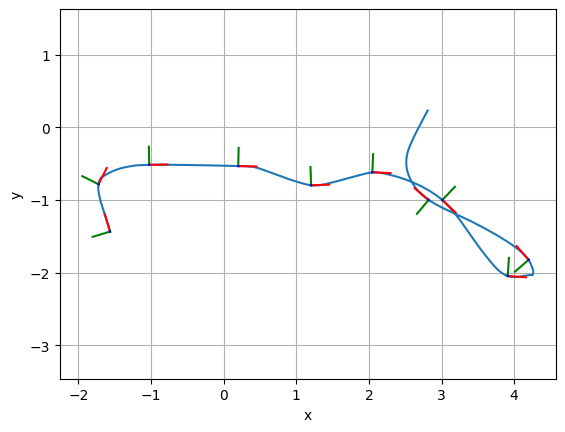

In [4]:
pose_data.plot2d(t0=200, tf=220, pose=False, dt=.1)
pose_data.plot2d(t0=200, tf=220, trajectory=False, pose=True, dt=2., axis_len=.25)

In [5]:
# T_BC = np.array([
#     - 0.0075156724929106855, 0.052520932013504995, 0.9985915413057593, 0.2101108603826516, - -0.999948500695071, -0.00641591694631477, 0.007863330555028802, 
#     -0.012497043173790775, - 0.00681986984179056, -0.9985992127526291, 0.05247000729150186, -0.0018691769405706252, - 0.0, 0.0, 0.0, 1.0
# ]).reshape((4, 4))

T_BC = np.array([0.031700555562911625, -0.03613229685936231, -0.9988440978954973, -0.3474637078784243, 0.9994936165740449, 
                 0.003899694308407531, 0.03158010152037666, -0.006910240015390966, 0.0027541250405664908, -0.9993394065621388, 0.03623762253919305, -0.11367298866636036, 0.0, 0.0, 0.0, 1.0
]).reshape((4, 4))
pose_data.T_postmultiply = T_BC
img_data.extract_params("/RR08/d455/color/camera_info")
cam_params = img_data.camera_params
fastsam = FastSAMWrapper(
    weights="/home/masonbp/tools/fastsam/weights/FastSAM-x.pt",
    imgsz=256,
    device='cpu'
)
img_area = cam_params.width * cam_params.height
fastsam.setup_filtering(
    ignore_people=True,
    yolo_det_img_size=(128, 128),
    allow_tblr_edges=[True, False, False, False],
    area_bounds=[img_area / 20**2, img_area / 3**2]
)


Fusing layers... 


In [6]:
all_observations = []
for t in np.arange(t0, tf, .05):
    try:
        img = img_data.img(t)
        pose = pose_data.T_WB(t)
    except:
        continue
    observations = fastsam.run(t, pose, img)
    all_observations.append(observations)
        
# print(segment.observations)
# print(len(segment.observations))


/home/masonbp/.envs/sparse_map/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

0: 160x256 7 objects, 90.5ms
Speed: 1.7ms preprocess, 90.5ms inference, 14.2ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 7 objects, 125.8ms
Speed: 0.7ms preprocess, 125.8ms inference, 17.1ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 8 objects, 104.5ms
Speed: 0.5ms preprocess, 104.5ms inference, 20.9ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 8 objects, 105.0ms
Speed: 0.3ms preprocess, 105.0ms inference, 18.6ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 10 objects, 110.9ms
Speed: 0.4ms preprocess, 110.9ms inference, 29.2ms postprocess per image at shape (1, 3, 256, 256)

0: 160x256 10 objec

In [7]:
tracker = Tracker(
    camera_params=cam_params,
    pixel_std_dev=10.0,
    min_iou=0.5,
    min_sightings=3,
    max_t_no_sightings=0.25,
    merge_objects=True
)

for observations in all_observations:
    if len(observations) > 0:
        tracker.update(observations[0].time, observations)


In [8]:
print(len(tracker.segments))
print(len(tracker.segment_nursery))
print(len(tracker.segment_graveyard))

5
7
62


[    0.33952    -0.94322     0.28824]
[    0.84951     0.64293     0.30163]


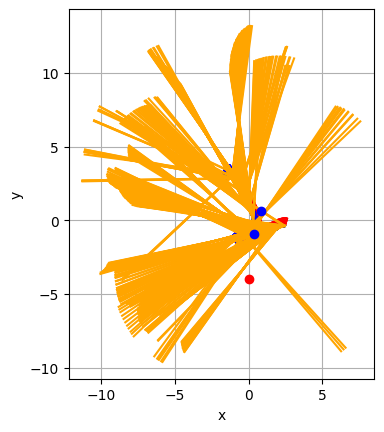

In [9]:
obs_lists = [seg.observations for seg in tracker.segments + tracker.segment_graveyard]
all_obs = [obs for obs_list in obs_lists for obs in obs_list]

plt.plot(0, -4, 'ro')
for obs in all_obs:
    pose_data.plot2d(t=obs.time, pose=True, axis_len=.5)
    
for obs in all_obs[:]:
    det_vec_c = np.linalg.inv(cam_params.K) @ np.array([obs.pixel[0], obs.pixel[1], 1]).reshape((3,1))
    det_vec = obs.pose[:3,:3] @ det_vec_c
    det_vec = det_vec[:2] / np.linalg.norm(det_vec[:2])
    det_vec *= 10
    plt.plot([obs.pose[0,3], obs.pose[0,3] + det_vec.item(0)], [obs.pose[1,3], obs.pose[1,3] + det_vec.item(1)], 'orange')

plt.gca().set_aspect('equal', adjustable='box')

for segment in tracker.segments:
    try:
        position = segment.reconstruction3D()
        print(position)
        plt.plot(position[0], position[1], 'bo')
    except:
        pass

In [10]:
boxes = np.array([
    [2.33, -2.03],
    [2.16, -1.65],
    [4.2, 0.5],
    [4.48, 1.73],
    [5.05, 3.24],
    [5.42, 3.43],
    [2.28, 1.94],
    [1.98, 2.19],
    [0.41, 2.39],
    [0.07, 2.64],
    [1.03, .48],
    [-1., 1.63],
    [-.86, -1.42],
    [-.33, -1.83],
    [-.73, -1.97],
    [-0.3, -3.46],
    [-1.79, 0.5],
    [-1.89, 1.13],
    [-2.86, 2.74],
    [-2.61, 2.78],
    [-3.37, 0.67],
    [-3.03, 0.19],
    [-2.36, -1.52],
])

In [16]:
def merge(self):
    """
    Merge segments with high overlap
    """
    max_iter = 100
    n = 0
    edited = True

    to_delete = []
    for seg in self.segment_graveyard:
        try:
            seg.reconstruction3D(width_height=True)
        except:
            to_delete.append(seg)
    for seg in to_delete:
        self.segment_graveyard.remove(seg)

    # repeatedly try to merge until no further merges are possible
    while n < max_iter and edited:
        edited = False
        n += 1

        for i, seg1 in enumerate(self.segment_graveyard):
            for j, seg2 in enumerate(self.segment_graveyard):
                if i >= j:
                    continue
                reconstruction = seg1.reconstruction3D(width_height=True)
                c1 = Cylinder(reconstruction[:3], 0.5*reconstruction[3], reconstruction[4])
                reconstruction = seg2.reconstruction3D(width_height=True)
                c2 = Cylinder(reconstruction[:3], 0.5*reconstruction[3], reconstruction[4])
                intersection = self.cylinder_intersection(c1, c2)
                combined_vol = c1.height * np.pi * c1.radius**2 + \
                    c2.height * np.pi * c2.radius**2
                iou = intersection / (combined_vol - intersection)
                if iou > self.merge_objects_iou:
                    for obs in seg2.observations:
                        seg1.update(obs)
                    self.segment_graveyard.pop(j)
                    edited = True
                    break
            if edited:
                break
    return

def cylinder_intersection(self, c1: Cylinder, c2: Cylinder):
    """
    Compute the intersection volume between two cylinders
    """
    d = np.linalg.norm(c1.position[:2] - c2.position[:2])
    if np.abs(c1.position[2] - c2.position[2]) > 0.5 * (c1.height + c2.height) \
        or d > c1.radius + c2.radius: # no intersection
        return 0.0
    intersecting_height = \
        (np.min([c1.position[2] + 0.5*c1.height, c2.position[2] + 0.5*c2.height]) # top
        - np.max([c1.position[2] - 0.5*c1.height, c2.position[2] - 0.5*c2.height])) # bottom
    if d <= np.abs(c1.radius - c2.radius): # one cylinder is inside the other
        return np.pi * np.min([c1.radius, c2.radius])**2 * intersecting_height
    r1 = c1.radius
    r2 = c2.radius
    return (r1**2 * np.arccos((d**2 + r1**2 - r2**2) / (2 * d * r1)) \
        + r2**2 * np.arccos((d**2 + r2**2 - r1**2) / (2 * d * r2)) \
        - 0.5 * np.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))) \
        * intersecting_height
            
merge(tracker)

[    0.33952    -0.94322     0.28824     0.19564     0.21437]
missed this one
missed this one
[    0.84951     0.64293     0.30163     0.24325     0.56346]
missed this one
[    -2.0383      4.5083     0.51647     0.80074     0.50679]
[     1.2055      7.6992      2.0227     0.35341      1.9819]
[    -7.3768       6.328      0.3216     0.98016      6.3182]
[   0.071824      2.7314     0.11118     0.22316      0.1911]
[   -0.59307      1.4638    0.087411      0.2862    0.077629]
[   -0.68272      6.6224      1.2176     0.94428      1.5957]
[    -1.8883      2.1624      0.2367     0.16981     0.21841]
[    0.47402      2.5996     0.24778      0.3245     0.48735]
[   -0.88838      1.7947    0.020787     0.45467    0.097303]
[    -1.1063      1.8251     0.24311     0.31299     0.69943]
[    -3.1839      6.3518     0.95632      1.5401      1.1468]
[  0.0088958      1.9984     0.52267     0.29344     0.48204]
[     1.1059     0.56158      0.2615     0.42886     0.54621]
[    -5.8111       1.6

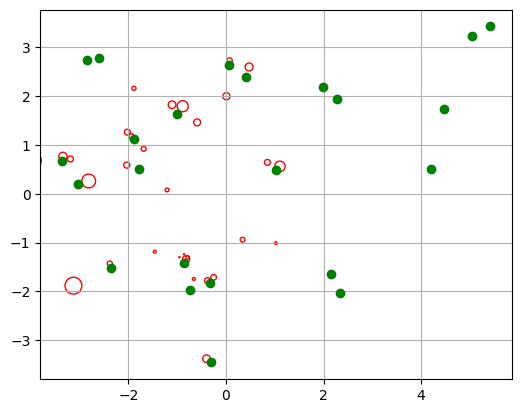

In [17]:
fig, ax = plt.subplots()
ax.plot(boxes[:,0], boxes[:,1], 'go')
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
for segment in tracker.segments + tracker.segment_graveyard:
    segment.camera_params = cam_params
    try:
        # reconstruction = segment.reconstruction3D(width_height=True)
        reconstruction = segment.reconstruction3D(width_height=True)
        print(reconstruction)
        ellipsoid = Ellipsoid(reconstruction[:2], axes=np.array([reconstruction[3]/2, reconstruction[3]/2]), rot_mat=np.eye(2))

        ellipsoid.plot2d(ax, edgecolor='r')
        # ax.plot(position[0], position[1], 'bx')
    except:
        print("missed this one")
# seg = tracker.segment_graveyard[10]
# reconstruction = reconstruction3D(seg, width_height=True)
# object = Object(reconstruction[:2])
# object.plot2d(ax)